In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

# pandas settings
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# seaborn settings
sns.set_style("darkgrid")

---

# Part 2 - EDA and Data Cleaning

---

### Contents

<a href = "part-1_reddit_scraper.ipynb">Part 1 - Reddit Scraper</a>


Part 2 - EDA and Data Cleaning


- [Preprossing for EDA and Data Cleaning](#Preprossing-for-EDA-and-Data-Cleaning)


- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Transformation using CountVectorizer](#Transformation-using-CountVectorizer)
    - [Custom Graphing Functions](#Custom-Graphing-Functions)
    - [Checking for Differing Words](#Checking-for-Differing-Words)


- [Data Cleaning](#Data-Cleaning)


- [Exporting Cleaned Data](#Exporting-Cleaned-Data)
 
 

<a href = "part-3_model_building.ipynb">Part 3 - Model Building</a><br>

---

## Preprossing for EDA and Data Cleaning
[top](#Contents)

The data scraped in the last notebook was imported and formatted into a dataframe. After a cursory examination, it was clear that the dataset contained extraneous information. The first step was to remove any duplicates. Due to the nature of subreddits, it was important to check for exact duplicates in both the "text" and "title" column, as posts could (and have been) reposted with just a change in either the text or title. All such duplicates were removed.

The columns "title", "selftext" and "subreddit" were then extracted and a new combined column labeled "text" was created. The text column then had links, punctuation, stopwords and short (len < 2) words removed, and the remaining words were lemmatized using WordNetLemmatizer. 

A decision was then made to examine any posts with less than 100 words, as the story-based nature of both subreddits meant that post texts are normally quite long. Only one of those posts (index 961) contained useful information, and the other posts were all removed from the dataset.

In [2]:
# importing dataset

data = pd.read_csv("data/raw_scrape_ps.csv")

In [3]:
# examining columns

data.columns

Index(['author', 'author_flair_css_class', 'author_flair_richtext',
       'author_flair_text', 'author_flair_type', 'author_fullname',
       'author_patreon_flair', 'can_mod_post', 'contest_mode', 'created_utc',
       'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'url', 'whitelist_status',
       'wls', 'author_cakeday', 'updated_utc', 'gilded', 'post_hint',
       'preview', 'edited'],
      dtype='object')

In [4]:
# extracting title, text and subreddit

sorted_df = data[data['selftext'] != "[removed]"][["title", "selftext", "subreddit"]]

In [5]:
# checking for null values

sorted_df.isnull().sum()

title        0
selftext     8
subreddit    0
dtype: int64

In [6]:
# examining selftext with null values

sorted_df[sorted_df["selftext"].isnull()]

,title,selftext,subreddit
408,Does anyone know how to make an account on bad...,NaN,pettyrevenge
872,"my boyfriend (gay) dumped me, so I catfished h...",NaN,ProRevenge
1020,Client stiffed me on payment after I SEO optim...,NaN,ProRevenge
1068,K,NaN,ProRevenge
1082,Identity thieves phone Njm,NaN,ProRevenge
1158,How I went “Heathers”,NaN,ProRevenge
1447,Pp touch,NaN,ProRevenge
1580,"Oof, I'm pretty sure my text text text text te...",NaN,ProRevenge


In [7]:
# the null value rows do not contain any useful information. Dropping rows.

sorted_df = sorted_df.dropna()

In [8]:
# checking for "selftext" duplicates

sorted_df[sorted_df['selftext'].duplicated()]

,title,selftext,subreddit
821,"so you don’t believe me, your best friend?",a friend of mine and i disagreed on whether a ...,ProRevenge
957,"I’m done playing, so I’m going to this",I have a brother (N). N is very hypocritical i...,ProRevenge
1080,"""You just coughed in my face!""","Obligatory, this happened years ago when I was...",ProRevenge
1117,I left my cheating ex-girlfriend homeless.,I ghosted a cheating ex once and it was extrem...,ProRevenge
1184,Entitled Parent takes friends switch for quote...,So I was with my 3 friends we will call them B...,ProRevenge
1197,My son's stepmom spanked him for bullying,he's 13 and his dad has primary custody but I ...,ProRevenge
1379,Teacher who locked me inside a School room. Go...,It was 5 or 4 years ago while I was at school....,ProRevenge
1384,"Fine, go ahead, splash on me.","First of all, forgive me for the gramatical er...",ProRevenge
1454,Got revenge on my cousin. X-post from Entitled...,A bit of Backgrounders info: So my Mom (who I ...,ProRevenge
1510,Argument over open window leads to students ge...,Not my own story but one my sister told me fro...,ProRevenge


In [9]:
# checking for "title" duplicates

sorted_df[sorted_df['title'].duplicated()]

,title,selftext,subreddit
670,Broke thieving roommate finally caught,Background: I live in an appartment with 3 roo...,pettyrevenge
835,Break into my house while i'm out of town? You...,Trying this again as my last post was removed ...,ProRevenge
863,The best way to get revenge on a narcissist?,Revenge On a Narcissist\n\nThe best way to get...,ProRevenge
869,My friends story,"So my ""friend"" decided to cheat on his fiance ...",ProRevenge
978,Asshole neighbor kept parking in front of my h...,A month ago I came home from work and found a ...,ProRevenge
1015,I unleashed a devastating fart on an obnoxious...,"After my undergrad study abroad program ended,...",ProRevenge
1080,"""You just coughed in my face!""","Obligatory, this happened years ago when I was...",ProRevenge
1097,I Tricked A Girl Into Believing That The Moon ...,"When I was in year 8 (7th grade in USA), there...",ProRevenge
1117,I left my cheating ex-girlfriend homeless.,I ghosted a cheating ex once and it was extrem...,ProRevenge
1197,My son's stepmom spanked him for bullying,he's 13 and his dad has primary custody but I ...,ProRevenge


In [10]:
# dropping duplicates

sorted_df.drop_duplicates(subset = "selftext", inplace = True)
sorted_df.drop_duplicates(subset = "title", inplace = True)

In [11]:
# examining final number of posts scraped from each subreddit

sorted_df["subreddit"].value_counts()

ProRevenge      852
pettyrevenge    811
Name: subreddit, dtype: int64

In [12]:
# creating a combination column from "title" and "selftext" named "text"

sorted_df['text'] = sorted_df["title"] +" "+ sorted_df["selftext"]

In [13]:
# custom function to process and lemmatize text

def post_worder (text):
    
    text = text.lower()
    
    # remove links
    text = re.sub(r'http\S+',"", text)
     
    # remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", text)   
    
    # convert post into individual words
    words = letters_only.split()
    
    # remove stopwords
    stops = set(stopwords.words('english'))
    words = [w for w in words if not w in stops]
    
    # words with 2 letters or less do not provide useful information (e.g. go, is). removing words.
    words = [w for w in words if len(w)>3]

    # Instantiate lemmatizer. 
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize tokens.
    tokens_lem = [lemmatizer.lemmatize(i, pos = "n") for i in words]
    
    return(" ".join(tokens_lem))

In [14]:
# applying function

sorted_df['text'] = sorted_df['text'].apply(post_worder)

In [15]:
# creating a wordcount column to examine posts with <100 words

sorted_df["wordcount"] = sorted_df['text'].str.len()

In [16]:
# checking for posts with <100 words.

sorted_df[sorted_df["wordcount"]<100]

,title,selftext,subreddit,text,wordcount
7,e,e,pettyrevenge,,0
10,Vui thôi đừng vui quá :)),Funny dog haha,pettyrevenge,funny haha,10
303,Would pay good money for this,Just saw this. There's only the one ex I have ...,pettyrevenge,would good money mind,21
341,Fart story,"My brother blamed me for farting at school, so...",pettyrevenge,fart story brother blamed farting school night...,64
522,(Request) I have a person phone number. I real...,Title,pettyrevenge,request person phone number really like anythi...,59
528,CALL THIS GUY AND DONT STOP,Hey guys so this guy was being mean to my favo...,pettyrevenge,call dont stop guy mean favorite streamer call...,98
582,Please sign,https://www.change.org/p/reddit-have-elon-mus...,pettyrevenge,please sign,11
717,Shadow,I think yes!!,pettyrevenge,shadow think,12
758,English poem,https://www.reddit.com/r/MaliciousCompliance/c...,pettyrevenge,english poem,12
961,You want me to take meds that I've repeatedly ...,I've been told that this would be a good fit o...,ProRevenge,want take med repeatedly told allergic okay en...,78


In [17]:
# since only one post is relevant, and that post has 86 words, 
# masking posts below 85 words and saving the preprocessed dataframe with a reset index

data = sorted_df[sorted_df["wordcount"]>85]
data.reset_index(drop=True, inplace=True)

---

## Exploratory Data Analysis
[top](#Contents)

When conducting Natural Language Processing, it is a requirement to vectorize the words. There are two main vectorization techniques commonly used: Count Vectorizer and TF-IDF (term frequency - inverse document frequencty) Vectorizer. Both of these scikit modules are methods of converting text into sparse matrices. The difference is that a count vectorizer only outputs the frequency of the words in the text, whereas a TF-IDF vectorizer outputs the relative weight of the word for the text.

While both vectorizers were tested, better results were gained using the CountVectorizer. The code below shows only the implementation of the CountVectorizer module, with the number of features limited to 1000.

An analysis of word lengths, text lengths and descriptions did not yield any significant information, and the code for that section was subsequently removed for readability.

Upon closer examination of the top occuring words, it was found that both datasets shared a large number of commonly occuring words. A graph was then plotted to determine how many of the top words were shared by both datasets.

### Transformation using CountVectorizer
[top](#Contents)

In [18]:
# Seperating posts by their subreddit

words_petty = data[data["subreddit"] == "pettyrevenge"]['text']
words_pro = data[data["subreddit"] == "ProRevenge"]['text']

In [19]:
# setting number of features

features = 1000

#initiating count vectorizer

cvec = CountVectorizer(max_features = features)

# vectorizing text

petty_eda = pd.DataFrame(cvec.fit_transform(words_petty).todense(),columns = cvec.get_feature_names())
pro_eda = pd.DataFrame(cvec.fit_transform(words_pro).todense(),columns = cvec.get_feature_names())

In [20]:
# Checking number of unique words for petty revenge

petty_eda.shape

(803, 1000)

In [21]:
# checking number of unique words for prorevenge

pro_eda.shape

(839, 1000)

### Custom Graphing Functions
[top](#Contents)

In [22]:
# function to find the top words and show count

def find_top_words(dataset, no_words):
    return (dataset.sum().sort_values(ascending = False).to_frame("frame").head(no_words))

In [23]:
# custom barplot

def top_words_barplot(dataset, title, no_words):
    
    sorted_df = find_top_words(dataset, no_words).reset_index()
    
    plt.figure(figsize=(15,8))
    ax = sns.barplot(x = sorted_df["frame"], y = sorted_df["index"], orient = "h")
    ax.set_title(title + "\n", fontsize = 18)
    ax.set_xlabel("Count", fontsize = 15)
    ax.set_ylabel("Words", fontsize = 15)
    plt.show()

In [24]:
# custom function to generate a wordcloud from text

wordcloud_petty = (' '.join(words_petty))
wordcloud_pro = (' '.join(words_pro))

def wordclouder(wc):

    wordcloud = WordCloud().generate(wc) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

### Graphical Representation of Petty Revenge and Pro Revenge
[top](#Contents)

As shown in the code and graphics below, a large number of top words were shared by pettyrevenge and prorevenge. The high occurance of several of these words can be explained by the meta-format for posts for both subreddits (e.g. one time, my friend in school...). There are also some terms which show an obvious relationship (school vs teacher).

These shared words need to be removed to generate lists of unique words, which will be done in the next step. 

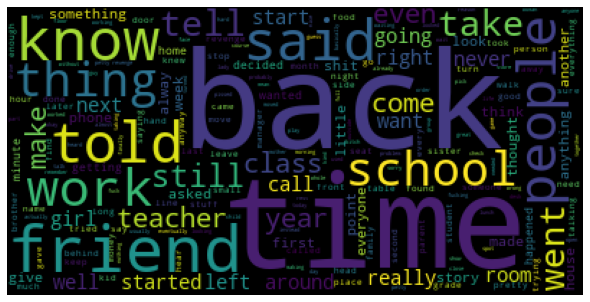

In [25]:
wordclouder(wordcloud_petty)

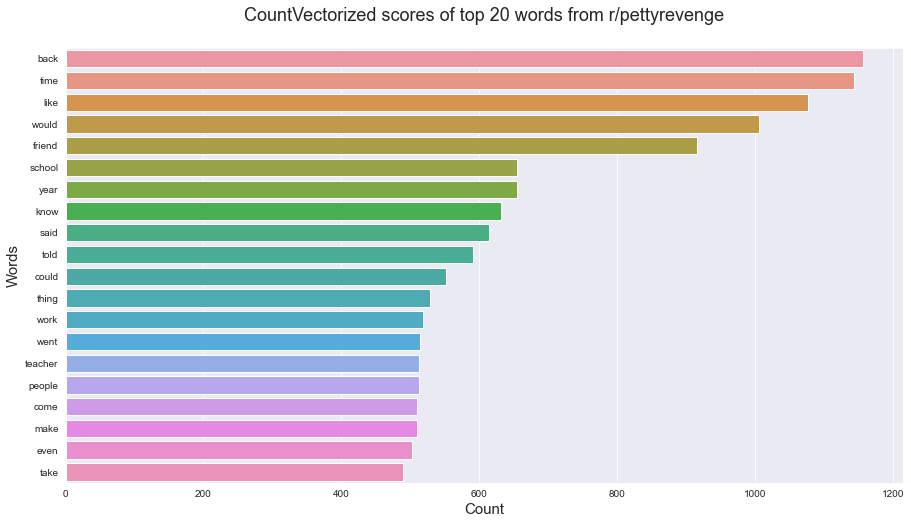

In [26]:
top_words_barplot(petty_eda, "CountVectorized scores of top 20 words from r/pettyrevenge", 20)

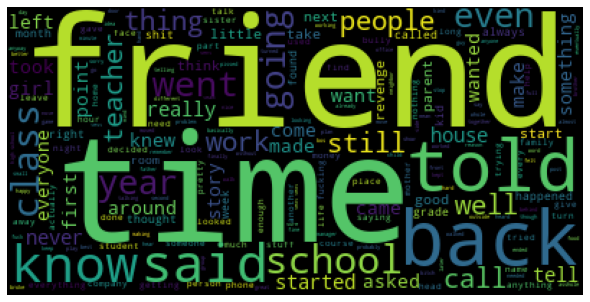

In [27]:
wordclouder(wordcloud_pro)

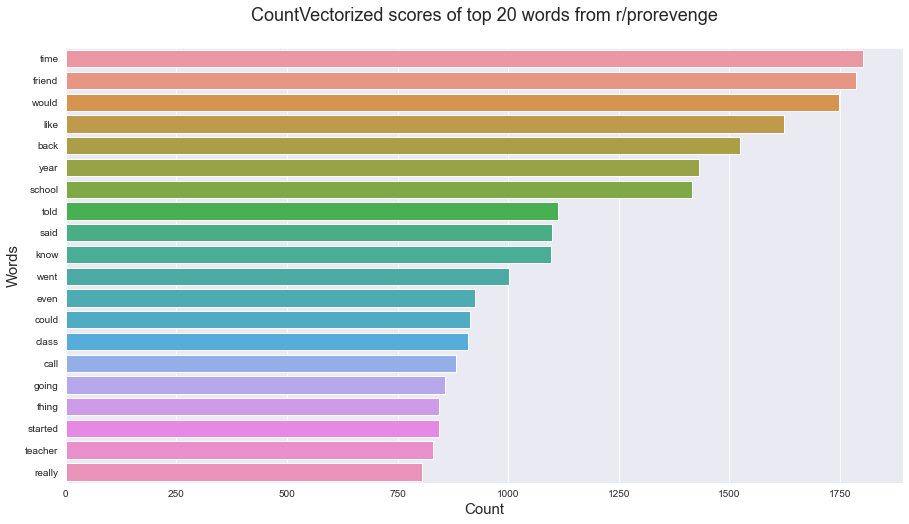

In [28]:
top_words_barplot(pro_eda, "CountVectorized scores of top 20 words from r/prorevenge", 20)

### Checking for Differing Words
[top](#Contents)

A graph was plotted below to show the number of differing words as compared to the total number of words. This provided a visual basis for the selection of the number of shared words to remove before enough differing words emerged for usage in modeling. 

As expected, the graph showed a linear increase in the number of differing words agaist the number of shared words. The lack of any sort of sharp increase implies that no words stood out significantly in count between both subreddits.

The final number of features that provided the highest accuracy while preventing overfitting was a minimum of 25 differing words, which required the removal of all shared words within the top 200 words of both subreddits.


In [29]:
# Sets the upper X-axis limit for the chart

no_of_words = 400

# creats a list with the count of the number of words which are different between both subreddits
diflist = []


testrange = range(1, no_of_words)

# appending number of different words to the diflist
for i in testrange:      
    
    list1 = list(find_top_words(petty_eda,i).index)
    list2 = list(find_top_words(pro_eda,i).index)
        
    shared_list = [word for word in list1 if word in list2]
    
    diflist.append(i - len(shared_list))

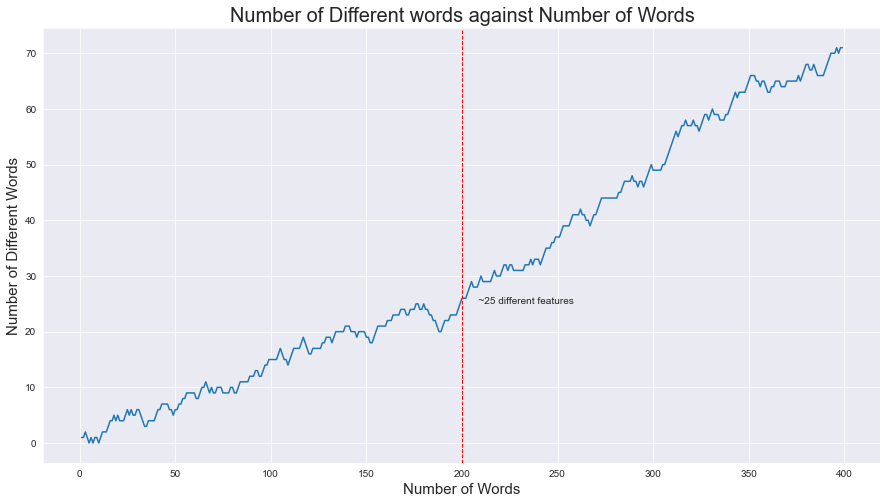

In [30]:
# Creating the lineplot

plt.figure(figsize=(15,8))

min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()

ax = sns.lineplot(x = testrange, y = diflist)
ax.set_title("Number of Different words against Number of Words", fontsize = 20)
ax.set_xlabel("Number of Words", fontsize = 15)
ax.set_ylabel("Number of Different Words", fontsize = 15)

# creating the line showing final selection

ax.axvline(200, color='red', linestyle='dashed', linewidth=1)  
ax.text(200, 25,'      ~25 different features')

plt.show()

---

## Data Cleaning
[top](#Contents)

As mentioned in the previous section, the shared top words for both subreddits were removed. 

Additionally, a quick analysis of the remaining words revealed that the word "petty" was present in the remaining wordlist for the pettyrevenge dataset. While this word would increase the accuracy of any subsequent classification model, it would not have helped in the original intent of identifying maliciousness. 

"petty" was subsequently removed from the final dataset. While "pro" was not in the top 20 words for the prorevenge dataset, a try/except function was used to drop "pro" from the final dataset as a precaution.

In [31]:
# Creating a function to return a list of shared words

def shared_words(data1, data2, no_w):
    
    for i in range (1, no_of_words):      
        
        list1 = list(find_top_words(data1,no_w).index)
        list2 = list(find_top_words(data2,no_w).index)
        
    shared_list = [word for word in list1 if word in list2]
    
    return shared_list

In [32]:
# setting number of top words to search through

no_words = 200

In [33]:
# creating a final dataset and removing shared words

final_df = pd.DataFrame(cvec.fit_transform(data['text']).todense(),columns = cvec.get_feature_names())
final_df.drop(columns = shared_words(petty_eda, pro_eda, no_words), inplace = True)

In [34]:
# removing "petty" and "pro" from the dataset.
for i in ["petty", "pro"]:
    try:
        final_df.drop(columns = [i], inplace = True)
    except:
        pass

---

## Exporting Cleaned Data
[top](#Contents)

After cleaning, the final dataset consists of 1642 vectors of 825 words. 

A visualization of the combined top 20 differing words for both subreddits showed that the top words were now skewed towards the workspace more than school (e.g. second highest word is company). This hinted at a change of malicousness with age.

The top word being "bully" also implied a significanct difference in maliciousness against someone with an intent to cause harm.

Both of these concepts were further explored in the modeling and discussion stages.

The final dataset was exported to a csv file, for subsequent use in modeling.

In [35]:
final_df.shape

(1642, 825)

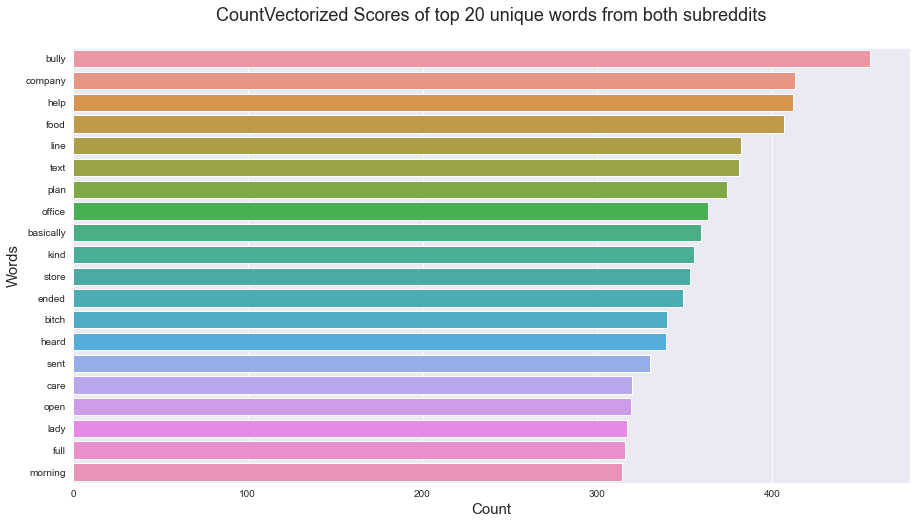

In [36]:
# creating a barplot of the top unique words

top_words_barplot(final_df, "CountVectorized Scores of top 20 unique words from both subreddits", 20)

In [37]:
# adding the subreddit back into the dataset

final_df['subreddit'] = data['subreddit']

In [38]:
# checking for errors

final_df.isnull().sum().sum()

0

In [39]:
# exporting to a csv file

pd.DataFrame(final_df).to_csv(f'data/final_cleaned.csv', index = False)